In [132]:
using ECOS, Convex, LinearAlgebra

In [133]:
n = 0.0010831 #constant mean motion of the target
nx = 6 # number of states
nu = 3 # number of control inputs
    
N = 2500  #number of frames 
    
thist = range(1, stop=N, length=N)
    
#Origin (Target Spacecraft Initial State)
x0_target = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] # x,y,z,vx,,vy,vz

#Chaser Spacecraft Initial State
x0_chaser = [15.0, 20.0, 15.0, 10.0, 10.0, 0.0]

dt = 1 #timestep

1

In [134]:
#CW equations expressed in statespace form 
#Create A Matrix
A = Array{Float64, 2}(undef, 6, 6)
A[1:3,:] = [zeros(Float64,3,3) Matrix(I,3,3)]
A[4,:] = [3*n^2, 0,0,0,2*n,0]
A[5,:] = [0,0,0,(-2*n),0,0]
A[6,:] = [0,0,-n^2, 0,0,0]

#Create B Matrix
B = [zeros(Float64,3,3); Matrix(I,3,3)]

6×3 Matrix{Float64}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

In [135]:
#Spacecraft Linear Dynamics
function spacecraft_dynamics(x,u)
    
    x_dot = A*x +B*u
    
return x_dot
    
end

spacecraft_dynamics (generic function with 1 method)

In [136]:
#change from continous to discrete 
H = exp(dt*[A B; zeros(nu,nx+nu)]) 

Ad = H[1:nx, 1:nx] 
Bd = H[1:nx,(nx+1):end]

6×3 Matrix{Float64}:
  0.5          0.000361033  0.0
 -0.000361033  0.5          0.0
  0.0          0.0          0.5
  1.0          0.0010831    0.0
 -0.0010831    0.999999     0.0
  0.0          0.0          1.0

In [137]:
#Initial position in Target centered coordinate frame
x_initial = x0_target+x0_chaser
#Set the goal as the Target position (for rendevouz)
x_goal = x0_target

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [138]:
#Create Convex.jl variables

In [139]:
X = Variable(nx, N)
U = Variable(nu, N-1)

Variable
size: (3, 2499)
sign: real
vexity: affine
id: 144…859

In [140]:
#Initial Condition Constraint
cons = Constraint[X[:,1] == x_initial]

#Initial Control Constraint
push!(cons, U[:,1] == 0)


#Dynamics Constraint
for k=1:(N-1)
    push!(cons, X[:,k+1] == Ad*X[:,k] + Bd*U[:,k])
end

#Goal Constraint 
push!(cons, X[:,N] == x_goal)

#Actuator Constraints
for k=1:(N-1)
    push!(cons, norm(U[k]) <= 0.06)
end

In [141]:
#Create optimization problem 
prob = minimize(norm(vec(U),1),cons) #vec(U) makes it a column vector

#Solve the problem 
solve!(prob, () -> ECOS.Optimizer())


ECOS 2.0.5 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -2.163e-24  -1.499e+02  +3e+04  3e-02  9e-01  1e+00  2e+00    ---    ---    1  2  - |  -  - 
 1  -1.533e+01  -3.281e+01  +1e+04  9e-04  1e-01  2e+00  5e-01  0.9890  3e-01   2  2  2 |  0  0
 2  -1.911e+00  -6.452e+00  +3e+03  2e-04  2e-02  6e-01  2e-01  0.7096  4e-02   2  3  2 |  0  0
 3  +1.221e+01  +1.015e+01  +2e+03  6e-05  1e-02  2e-01  8e-02  0.6447  2e-01   2  2  2 |  0  0
 4  +1.949e+01  +1.828e+01  +9e+02  3e-05  5e-03  1e-01  4e-02  0.5152  2e-01   2  3  3 |  0  0
 5  +2.275e+01  +2.198e+01  +5e+02  2e-05  3e-03  7e-02  3e-02  0.4748  2e-01   3  3  3 |  0  0
 6  +2.421e+01  +2.373e+01  +3e+02  1e-05  2e-03  4e-02  1e-02  0.4884  2e-01   3  3  3 |  0  0
 7  +2.457e+01  +2.430e+01  +1e+02  6e-06  1e-03  2e-02  7e-03  0.5547  1e-01   3  3  2 |  0  0
 8  +2.409e+01  +2.400e+01  +4e+01  2e-06  4e-

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/fausto/.julia/packages/Convex/uI27T/src/solution.jl:263


In [142]:
Xm = X.value
Um  = U.value
print(size(Xm))
print(Xm[1,:])

(6, 2500)[15.000000000000417, 25.010855438781203, 35.01339226334858, 44.977490433467814, 54.90300828822591, 64.78980421196816, 74.6377366344638, 84.44666403107479, 94.21644492292037, 103.94693787704271, 113.6380015065733, 123.28949447089771, 132.9012754758222, 142.47320327373941, 152.00513666379396, 161.49693449204918, 170.9484556516505, 180.35955908299263, 189.73010377388513, 199.05994875971734, 208.34895312362391, 217.59697599664966, 226.80387655791557, 235.96951403478312, 245.09374770301983, 254.17643688696432, 263.2174409596915, 272.2166193431776, 281.17383150846564, 290.08893697582874, 298.9617953149355, 307.7922661450166, 316.5802091350277, 325.32548400381353, 334.0279505202724, 342.68746850352176, 351.3038978230635, 359.8770983989464, 368.4069302019319, 376.89325325365746, 385.3359276268009, 393.7348134452447, 402.0897708842404, 410.4006601705726, 418.6673415827221, 426.88967545103066, 435.06752215786497, 443.2007421377796, 451.2891958776812, 459.3327439169919, 467.331246847814,

, 748.252903063453, 747.2622162189738, 746.2717391273363, 745.2814729504756, 744.2914188500793, 743.3015779875861, 742.3119515241848, 741.3225406208121, 740.3333464381524, 739.3443701366357, 738.3556128764361, 737.3670758174713, 736.3787601194003, 735.3906669416224, 734.4027974432757, 733.4151527832363, 732.4277341201164, 731.4405426122628, 730.453579417756, 729.4668456944089, 728.480342599765, 727.4940712910968, 726.5080329254055, 725.5222286594189, 724.53665964959, 723.5513270520959, 722.5662320228364, 721.5813757174324, 720.596759291225, 719.6123838992738, 718.6282506963556, 717.6443608369632, 716.6607154753035, 715.6773157652972, 714.6941628605763, 713.7112579144836, 712.7286020800707, 711.7461965100973, 710.7640423570294, 709.7821407730378, 708.8004929099973, 707.8190999194851, 706.837962952779, 705.8570831608567, 704.8764616943946, 703.896099703765, 702.915998339037, 701.9361587499732, 700.9565820860292, 699.9772694963525, 698.9982221297804, 698.0194411348393, 697.0409276597429, 

 276.3754086184014, 275.6521908815874, 274.9297361457794, 274.20804525849155, 273.48711906634225, 272.7669584150528, 272.04756414944626, 271.32893711344667, 270.611078150078, 269.89398810146344, 269.1776678088238, 268.4621181124771, 267.7473398518373, 267.0333338654133, 266.32010099080816, 265.607642064718, 264.8959579229309, 264.18504940032614, 263.47491733087304, 262.7655625476301, 262.05698588274385, 261.3491881674481, 260.64217023206305, 259.9359329059937, 259.2304770177297, 258.5258033948437, 257.8219128639909, 257.1188062509077, 256.4164843804109, 255.71494807639672, 255.01419816183983, 254.31423545879238, 253.615060788383, 252.91667497081588, 252.21907882536988, 251.5222731703973, 250.8262588233233, 250.13103660064448, 249.4366073179286, 248.74297178981283, 248.0501308300034, 247.3580852512743, 246.66683586546648, 245.9763834834869, 245.28672891530744, 244.5978729699643, 243.90981645555644, 243.22256017924533, 242.53610494725345, 241.85045156486373, 241.16560083641824, 240.48155

, 18.404386850649654, 18.176227056618764, 17.94913230675776, 17.723102867449377, 17.498139003826452, 17.27424097977159, 17.05140905791687, 16.829643499643502, 16.608944565081533, 16.389312513109505, 16.170747601354186, 15.953250086190243, 15.736820222739958, 15.521458264872962, 15.307164465205904, 15.093939075102142, 14.881782344671391, 14.670694522769352, 14.460675856997314, 14.251726593701777, 14.043846977974116, 13.837037253650283, 13.631297663310612, 13.426628448279656, 13.223029848626089, 13.020502103162597, 12.819045449445696, 12.618660123775468, 12.419346361195158, 12.221104395490647, 12.023934459189835, 11.827836783562018, 11.632811598617304, 11.438859133106194, 11.245979614519358, 11.054173269087618, 10.86344032178212, 10.67378099631461, 10.485195515137695, 10.297684099444952, 10.111246969170825, 9.925884342990216, 9.741596438317805, 9.558383471307149, 9.376245656849743, 9.19518320857419, 9.015196338845598, 8.836285258765367, 8.658450178171321, 8.481691305638167, 8.30600884847

 -3.536493778274847, -3.5279818452901863, -3.519465772422324, -3.510945569675408, -3.502421247058755, -3.4938928145868537, -3.485360282279358, -3.476823660161054, -3.4682829582618226, -3.459738186616585, -3.451189355265233, -3.442636474252561, -3.4340795536281763, -3.4255186034464167, -3.4169536337662634, -3.4083846546512504, -3.3998116761693873, -3.3912347083930787, -3.3826537613990606, -3.374068845268346, -3.3654799700861773, -3.356887145942, -3.3482903829294477, -3.339689691146338, -3.3310850806946872, -3.3224765616807344, -3.313864144214976, -3.3052478384122113, -3.2966276543915933, -3.288003602276688, -3.279375692195528, -3.2707439342806714, -3.262108338669258, -3.2534689155030545, -3.2448256749284936, -3.236178627096709, -3.22752778216355, -3.218873150289591, -3.2102147416401245, -3.201552566385144, -3.1928866346993114, -3.1842169567619143, -3.175543542756817, -3.166866402872397, -3.158185547301479, -3.149500986241264, -3.140812729893256, -3.1321207884631925, -3.1234251721609727,

In [143]:
print(Um)

[5.118782349392298e-11 -0.05999999825903433 -0.0599999982516363 -0.05999999824199275 -0.059999998235691805 -0.0599999982279916 -0.059999998218416666 -0.05999999821004731 -0.05999999820080452 -0.05999999819157214 -0.059999998183846145 -0.059999998174309385 -0.05999999816656108 -0.05999999815720058 -0.05999999814745221 -0.05999999814040044 -0.05999999812991533 -0.0599999981213586 -0.05999999811112765 -0.05999999810213983 -0.05999999809201642 -0.05999999808226319 -0.0599999980729682 -0.05999999806279676 -0.05999999805353662 -0.059999998043519055 -0.059999998032757476 -0.059999998022168675 -0.05999999801227331 -0.05999999800207734 -0.05999999798906443 -0.0599999979789113 -0.0599999979671045 -0.05999999795812906 -0.059999997945961475 -0.05999999793434469 -0.05999999792339721 -0.059999997910666764 -0.05999999789975888 -0.05999999788728051 -0.05999999787644909 -0.059999997862670615 -0.0599999978510325 -0.059999997838880326 -0.059999997825455315 -0.059999997813135524 -0.0599999977997265 -0.059

 -8.225750219262837e-10 -8.18769437425248e-10 -8.14993023261446e-10 -8.112454375672715e-10 -8.075263437637882e-10 -8.038354104590368e-10 -8.001723113487441e-10 -7.965367251192986e-10 -7.929283353529227e-10 -7.893468304349766e-10 -7.857919034634446e-10 -7.822632521603677e-10 -7.787605787853133e-10 -7.752835900507944e-10 -7.718319970395423e-10 -7.684055151236496e-10 -7.650038638854578e-10 -7.616267670402519e-10 -7.582739523606014e-10 -7.549451516023921e-10 -7.516401004324365e-10 -7.483585383577064e-10 -7.451002086560588e-10 -7.418648583084697e-10 -7.386522379327275e-10 -7.354621017185356e-10 -7.322942073640338e-10 -7.291483160136246e-10 -7.260241921971527e-10 -7.229216037703475e-10 -7.198403218565365e-10 -7.167801207895939e-10 -7.13740778057997e-10 -7.107220742501986e-10 -7.077237930009925e-10 -7.047457209390456e-10 -7.01787647635564e-10 -6.988493655538754e-10 -6.959306700002178e-10 -6.930313590753752e-10 -6.901512336274034e-10 -6.872900972052736e-10 -6.844477560134454e-10 -6.81624018867

 -1.8405061275350474e-10 -1.834817832649147e-10 -1.829146211697817e-10 -1.8234912182822979e-10 -1.8178528063799682e-10 -1.8122309303413125e-10 -1.8066255448872657e-10 -1.801036605106908e-10 -1.7954640664543153e-10 -1.789907884746198e-10 -1.7843680161595029e-10 -1.7788444172282794e-10 -1.7733370448415914e-10 -1.7678458562409918e-10 -1.7623708090178212e-10 -1.7569118611105387e-10 -1.7514689708026717e-10 -1.746042096720105e-10 -1.7406311978286753e-10 -1.7352362334317042e-10 -1.7298571631676985e-10 -1.724493947008009e-10 -1.7191465452542325e-10 -1.7138149185361066e-10 -1.7084990278090794e-10 -1.7031988343520226e-10 -1.6979142997649013e-10 -1.6926453859665656e-10 -1.6873920551924542e-10 -1.682154269992326e-10 -1.6769319932281528e-10 -1.6717251880718194e-10 -1.6665338180028845e-10 -1.6613578468064883e-10 -1.6561972385713176e-10 -1.6510519576871878e-10 -1.6459219688431103e-10 -1.640807237025196e-10 -1.635707727514581e-10 -1.6306234058850135e-10 -1.6255542380014303e-10 -1.620500190017177e-10 -

 -6.415946972149715e-11 -6.416067733454217e-11 -6.416313372575848e-11 -6.416683939538179e-11 -6.417179484665022e-11 -6.417800058582121e-11 -6.418545712217962e-11 -6.419416496803471e-11 -6.420412463875152e-11 -6.421533665273213e-11 -6.422780153145916e-11 -6.424151979946199e-11 -6.42564919843631e-11 -6.427271861686767e-11 -6.429020023078585e-11 -6.430893736303969e-11 -6.432893055365441e-11 -6.435018034579961e-11 -6.43726872857879e-11 -6.439645192308232e-11 -6.44214748102999e-11 -6.444775650325121e-11 -6.447529756091577e-11 -6.450409854548845e-11 -6.453416002237239e-11 -6.456548256018457e-11 -6.459806673079132e-11 -6.463191310929973e-11 -6.466702227409233e-11 -6.470339480681403e-11 -6.474103129240353e-11 -6.477993231912295e-11 -6.482009847852154e-11 -6.486153036550075e-11 -6.490422857830234e-11 -6.494819371853281e-11 -6.499342639117467e-11 -6.503992720460105e-11 -6.508769677059253e-11 -6.513673570434908e-11 -6.518704462451349e-11 -6.523862415318127e-11 -6.529147491592253e-11 -6.5345597541

 -2.0015119988638837e-10 -2.0083300533671464e-10 -2.015169813227301e-10 -2.0220313250611344e-10 -2.0289146354011702e-10 -2.035819790658739e-10 -2.0427468370872587e-10 -2.0496958207355408e-10 -2.05666678733725e-10 -2.063659782179545e-10 -2.070674850163822e-10 -2.0777120358029225e-10 -2.0847713830528791e-10 -2.0918529353039955e-10 -2.0989567351796638e-10 -2.106082824274298e-10 -2.1132312424127054e-10 -2.1204020277650647e-10 -2.1275952178651636e-10 -2.134810846607689e-10 -2.1420489462379175e-10 -2.1493095509702287e-10 -2.1565926968568443e-10 -2.1638984184891504e-10 -2.1712267457666483e-10 -2.1785777010844423e-10 -2.1859513087589813e-10 -2.1933476043141392e-10 -2.2007666271352742e-10 -2.2082084348061184e-10 -2.2156730969884755e-10 -2.2231606778215557e-10 -2.2306712418423492e-10 -2.2382048541427955e-10 -2.245761580372584e-10 -2.2533414867404906e-10 -2.2609446400167084e-10 -2.2685711075353437e-10 -2.2762209571975246e-10 -2.283894257474263e-10 -2.2915910774094054e-10 -2.2993114866228597e-10 -

 -9.505225926349492e-10 -9.54781244435354e-10 -9.590702482482967e-10 -9.633899432136615e-10 -9.677406735626699e-10 -9.721227887136377e-10 -9.765366433699617e-10 -9.809825976202653e-10 -9.85461017040883e-10 -9.899722728006791e-10 -9.945167417682774e-10 -9.990948066217605e-10 -1.0037068559609425e-9 -1.008353284422228e-9 -1.0130344927961686e-9 -1.0177508881477885e-9 -1.0225028839397119e-9 -1.0272909001582514e-9 -1.0321153634424583e-9 -1.0369767072162606e-9 -1.0418753718237676e-9 -1.0468118046678073e-9 -1.0517864603518565e-9 -1.0567998008253553e-9 -1.0618522955325984e-9 -1.0669444215652371e-9 -1.0720766638185413e-9 -1.0772495151515089e-9 -1.082463476550934e-9 -1.087719057299546e-9 -1.0930167751483474e-9 -1.0983571564932839e-9 -1.1037407365563217e-9 -1.1091680595711443e-9 -1.114639678973509e-9 -1.1201561575965267e-9 -1.1257180678708425e-9 -1.1313259920300563e-9 -1.1369805223213651e-9 -1.142682261221714e-9 -1.1484318216595567e-9 -1.1542298272424192e-9 -1.1600769124904215e-9 -1.16597372307597

 -7.101997198838265e-9 -6.906602880807855e-9 -6.721775647873755e-9 -6.546681284963662e-9 -6.380571138071498e-9 -6.2227714190868275e-9 -6.072674075776494e-9 -5.929728966059115e-9 -5.7934371242446916e-9 -5.663344945517289e-9 -5.53903914582259e-9 -5.420142379163111e-9 -5.306309414389641e-9 -5.19722378989494e-9 -5.092594877938095e-9 -4.99215530125086e-9 -4.895658653573518e-9 -4.802877483206589e-9 -4.713601504840267e-9 -4.627636010087416e-9 -4.544800451358111e-9 -4.464927177465006e-9 -4.3878603023775606e-9 -4.313454690986183e-9 -4.241575048008388e-9 -4.17209509800427e-9 -4.104896846046071e-9 -4.039869909935842e-9 -3.976910916021373e-9 -3.91592295165433e-9 -3.856815068190641e-9 -3.799501829172692e-9 -3.74390289897273e-9 -3.689942667732464e-9 -3.6375499089165563e-9 -3.5866574662186214e-9 -3.537201966925951e-9 -3.4891235591703885e-9 -3.442365670775048e-9 -3.3968747876540386e-9 -3.352600249940097e-9 -3.3094940642074982e-9 -3.2675107303268503e-9 -3.226607081638814e-9 -3.186742137266479e-9 -3.147

 -6.912269513285318e-10 -6.907466172473214e-10 -6.902725169493484e-10 -6.898046301185692e-10 -6.893429366725406e-10 -6.888874167604288e-10 -6.884380507609064e-10 -6.879948192802325e-10 -6.87557703150213e-10 -6.871266834263095e-10 -6.867017413856728e-10 -6.862828585252704e-10 -6.858700165600247e-10 -6.854631974209373e-10 -6.850623832533262e-10 -6.846675564149534e-10 -6.842786994743102e-10 -6.838957952088434e-10 -6.835188266032355e-10 -6.831477768477039e-10 -6.82782629336326e-10 -6.824233676653516e-10 -6.82069975631603e-10 -6.817224372308569e-10 -6.813807366562103e-10 -6.810448582965592e-10 -6.807147867350346e-10 -6.803905067474417e-10 -6.800720033007989e-10 -6.797592615517962e-10 -6.794522668453732e-10 -6.791510047132372e-10 -6.788554608724516e-10 -6.785656212239954e-10 -6.782814718514086e-10 -6.780029990193805e-10 -6.777301891724351e-10 -6.77463028933548e-10 -6.772015051028487e-10 -6.769456046563327e-10 -6.766953147445502e-10 -6.764506226913572e-10 -6.762115159926436e-10 -6.75977982315

 -1.0481416944382838e-9 -1.0505952634895893e-9 -1.0530606098782883e-9 -1.055537791084888e-9 -1.0580268650124231e-9 -1.0605278899899088e-9 -1.0630409247758063e-9 -1.0655660285615472e-9 -1.0681032609750692e-9 -1.070652682084403e-9 -1.0732143524013014e-9 -1.0757883328848791e-9 -1.0783746849453099e-9 -1.080973470447558e-9 -1.083584751715154e-9 -1.0862085915339883e-9 -1.0888450531561662e-9 -1.0914942003038683e-9 -1.094156097173328e-9 -1.096830808438725e-9 -1.0995183992562365e-9 -1.102218935268075e-9 -1.1049324826065627e-9 -1.1076591078982557e-9 -1.1103988782681423e-9 -1.113151861343832e-9 -1.115918125259811e-9 -1.118697738661753e-9 -1.1214907707108767e-9 -1.1242972910883036e-9 -1.127117369999511e-9 -1.1299510781788184e-9 -1.132798486893904e-9 -1.1356596679503825e-9 -1.1385346936964243e-9 -1.1414236370274424e-9 -1.14432657139079e-9 -1.1472435707905332e-9 -1.150174709792278e-9 -1.1531200635280232e-9 -1.1560797077010971e-9 -1.1590537185911202e-9 -1.1620421730590125e-9 -1.1650451485520993e-9 -1

 -1.757997926254695e-8 -1.741646801321282e-8 -1.7067480638995343e-8 -1.6647235067707495e-8 -1.6296525353302873e-8 -1.6151015546613424e-8 -1.6307555299232752e-8 -1.6796863436293374e-8 -1.7570289537222316e-8 -1.8505606424488762e-8 -1.9432346672985646e-8 -2.017205531550158e-8 -2.0584319981225965e-8 -2.0606902398501674e-8 -2.027869183967003e-8 -1.97377710636128e-8 -1.9192979834898954e-8 -1.887451937836845e-8 -1.8975420274821164e-8 -1.95991920049346e-8 -2.0728398922246445e-8 -2.2224062458773867e-8 -2.385773435371189e-8 -2.5368944269966426e-8 -2.6533121366550036e-8 -2.722137825786119e-8 -2.7435071353092937e-8 -2.730466917813089e-8 -2.7052482476238135e-8 -2.692941278427372e-8 -2.714387536532404e-8 -2.7803851479091286e-8 -2.8889472902430225e-8 -3.0264423361206756e-8 -3.1722394965605024e-8 -3.305364363717967e-8 -3.411009170443779e-8 -3.484784888927313e-8 -3.533360779350111e-8 -3.571375338441177e-8 -3.615799863909973e-8 -3.679826834901258e-8 -3.7685005482417816e-8 -3.877631051986004e-8 -3.996269

 -7.546603276456606e-9 -7.336911912367272e-9 -7.1038919703827425e-9 -6.854095040779207e-9 -6.594637174067448e-9 -6.332946995742526e-9 -6.076502904108524e-9 -5.8325687692424055e-9 -5.60793763110847e-9 -5.408692627171782e-9 -5.239993772477353e-9 -5.105898288910622e-9 -5.0092209681034545e-9 -4.9514395975416195e-9 -4.932648835842388e-9 -4.951564150608798e-9 -5.005575597208022e-9 -5.090849387004826e-9 -5.202473437606592e-9 -5.334641481296667e-9 -5.480868891459203e-9 -5.634232224005129e-9 -5.787623605118822e-9 -5.934010560906814e-9 -6.0666916992789334e-9 -6.179538826421511e-9 -6.267216604352872e-9 -6.325371711434775e-9 -6.350784624309193e-9 -6.341478552506377e-9 -6.2967816741042564e-9 -6.2173405809679205e-9 -6.105084678641943e-9 -5.963143129355078e-9 -5.7957177074564e-9 -5.607916585568777e-9 -5.405555525757624e-9 -5.1949341555086945e-9 -4.982595918356168e-9 -4.775080868396399e-9 -4.57868070391222e-9 -4.399205301394557e-9 -4.241769520730972e-9 -4.110608227615928e-9 -4.00892635102411e-9 -3.938

 3.739057787351944e-11 3.813493411583641e-11 3.8879507159341493e-11 3.962430162997186e-11 4.036932215687514e-11 4.111457337248948e-11 4.1860059912613035e-11 4.2605786416455336e-11 4.3351757526734103e-11 4.409797788969913e-11 4.484445215523957e-11 4.559118497693426e-11 4.6338181012110895e-11 4.708544492192891e-11 4.783298137144373e-11 4.858079502965841e-11 4.932889056960536e-11 5.0077272668431656e-11 5.082594600741601e-11 5.1574915272087953e-11 5.232418515227396e-11 5.307376034216763e-11 5.382364554039102e-11 5.457384545007733e-11 5.532436477892705e-11 5.607520823928767e-11 5.6826380548203996e-11 5.757788642752552e-11 5.832973060391907e-11 5.908191780897996e-11 5.983445277930313e-11 6.058734025652e-11 6.134058498740046e-11 6.209419172389934e-11 6.28481652232454e-11 6.360251024799382e-11 6.43572315661184e-11 6.511233395105143e-11 6.586782218177627e-11 6.662370104290394e-11 6.737997532472211e-11 6.813664982328236e-11 6.889372934045663e-11 6.965121868402077e-11 7.040912266773314e-11 7.1167

 4.927600202285843e-10 4.943001177980714e-10 4.958445240998455e-10 4.973932589609206e-10 4.989463423094591e-10 5.00503794175396e-10 5.02065634691113e-10 5.036318840921066e-10 5.052025627176659e-10 5.06777691011548e-10 5.083572895226338e-10 5.099413789056516e-10 5.115299799218528e-10 5.13123113439705e-10 5.147208004355966e-10 5.163230619945572e-10 5.179299193109404e-10 5.195413936891823e-10 5.211575065444855e-10 5.22778279403575e-10 5.244037339054283e-10 5.260338918019911e-10 5.276687749589642e-10 5.293084053565199e-10 5.309528050900755e-10 5.326019963710474e-10 5.342560015276238e-10 5.359148430055422e-10 5.3757854336886e-10 5.392471253007499e-10 5.409206116042788e-10 5.425990252032272e-10 5.442823891428678e-10 5.459707265907894e-10 5.476640608377126e-10 5.493624152983119e-10 5.510658135120389e-10 5.52774279143955e-10 5.544878359855931e-10 5.562065079557829e-10 5.579303191015063e-10 5.596592935987808e-10 5.613934557534906e-10 5.631328300023021e-10 5.648774409135121e-10 5.666273131879518

 2.527981709962104e-9 2.539326302898489e-9 2.550742512866855e-9 2.562230947551622e-9 2.5737922210834503e-9 2.585426954121511e-9 2.5971357739369797e-9 2.608919314497777e-9 2.6207782165545546e-9 2.632713127728055e-9 2.6447247025976497e-9 2.6568136027913515e-9 2.6689804970770954e-9 2.6812260614554326e-9 2.693550979253649e-9 2.705955941221262e-9 2.718441645627055e-9 2.7310087983574953e-9 2.7436581130167613e-9 2.7563903110282043e-9 2.7692061217374712e-9 2.7821062825171052e-9 2.795091538872887e-9 2.808162644551707e-9 2.8213203616511913e-9 2.834565460730975e-9 2.8478987209257753e-9 2.8613209300601476e-9 2.8748328847651225e-9 2.8884353905966007e-9 2.9021292621556594e-9 2.915915323210733e-9 2.929794406821721e-9 2.9437673554660745e-9 2.957835021166863e-9 2.971998265622908e-9 2.986257960340952e-9 3.0006149867699715e-9 3.015070236437623e-9 3.0296246110888987e-9 3.044279022826964e-9 3.0590343942563317e-9 3.0738916586282926e-9 3.088851759988749e-9 3.103915653328412e-9 3.119084304735449e-9 3.13435869

 2.0203297171211348e-5 1.4496479613289733e-5 1.0902819677254174e-5 8.495003446020398e-6 6.803687902611941e-6 5.570636981590498e-6 4.6442387860278464e-6 3.93073350511741e-6 3.369616701292947e-6 2.9204316857134754e-6 2.5552992553074957e-6 2.254503528234694e-6 2.003784321398698e-6 1.7926217945560598e-6 1.6131186251319914e-6 1.4592532195900156e-6 1.326369649320157e-6 1.2108223075177917e-6 1.1097239018935532e-6 1.0207638240375218e-6 9.42075304645404e-7 8.721369376237625e-7 8.096987767077251e-7 7.537262405026792e-7 7.033570862651819e-7 6.578680858180977e-7 6.166489819722092e-7 5.791819630975391e-7 5.450253592027983e-7 5.138005958118386e-7 4.851816825012511e-7 4.588866886373051e-7 4.3467078835550763e-7 4.123205531680748e-7 3.916492428724273e-7 3.7249290011124243e-7 3.5470709560947417e-7 3.3816420310143696e-7 3.227511076940592e-7 3.0836727064511014e-7 2.949230885979441e-7 2.823384971698254e-7 2.705417781809448e-7 2.5946853728507314e-7 2.490608247433119e-7 2.392663768906727e-7 2.300379597295128

 2.4177078626126606e-9 2.4070817103146482e-9 2.396520556806339e-9 2.386023869253723e-9 2.3755911202598485e-9 2.3652217877983427e-9 2.3549153551478987e-9 2.344671310827679e-9 2.3344891485336412e-9 2.3243683670757473e-9 2.314308470316097e-9 2.3043089671078693e-9 2.2943693712352057e-9 2.284489201353856e-9 2.2746679809327186e-9 2.2649052381961462e-9 2.2552005060671117e-9 2.245553322111102e-9 2.235963228480852e-9 2.2264297718617947e-9 2.216952503418314e-9 2.207530978740685e-9 2.198164757792788e-9 2.188853404860552e-9 2.17959648850104e-9 2.170393581492309e-9 2.161244260783895e-9 2.1521481074480323e-9 2.1431047066314772e-9 2.134113647508023e-9 2.125174523231663e-9 2.1162869308903595e-9 2.107450471460471e-9 2.098664749761765e-9 2.0899293744130494e-9 2.081243957788412e-9 2.0726081159740196e-9 2.0640214687255246e-9 2.055483639426025e-9 2.0469942550445786e-9 2.038552946095277e-9 2.0301593465968894e-9 2.021813094032982e-9 2.013513829312629e-9 2.0052611967315887e-9 1.997054843934045e-9 1.9888944218

 4.723579700380463e-10 4.70854188587912e-10 4.69354519249659e-10 4.678589433309617e-10 4.663674422327022e-10 4.64879997448363e-10 4.633965905634783e-10 4.6191720325500103e-10 4.6044181729074455e-10 4.5897041452879233e-10 4.57502976916944e-10 4.5603948649212483e-10 4.545799253798362e-10 4.531242757935696e-10 4.5167252003428267e-10 4.502246404898199e-10 4.4878061963437686e-10 4.4734044002794575e-10 4.4590408431577194e-10 4.444715352278354e-10 4.4304277557828177e-10 4.4161778826492554e-10 4.4019655626870713e-10 4.3877906265317784e-10 4.373652905639689e-10 4.359552232282729e-10 4.3454884395436377e-10 4.331461361310436e-10 4.31747083227178e-10 4.3035166879116447e-10 4.289598764504493e-10 4.275716899110336e-10 4.2618709295697937e-10 4.248060694499224e-10 4.2342860332858546e-10 4.2205467860829904e-10 4.2068427938054034e-10 4.1931738981241975e-10 4.179539941462478e-10 4.1659407669906063e-10 4.152376218621428e-10 4.1388461410057013e-10 4.125350379527563e-10 4.1118887803000416e-10 4.098461190160

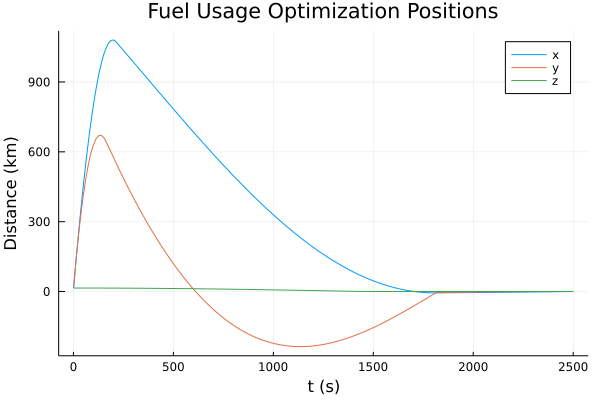

In [151]:
using Plots
Plots.plot(Xm'[:,1:3], title="Fuel Usage Optimization Positions",xaxis="t (s)", yaxis="Distance (km)", labels=["x" "y" "z"])

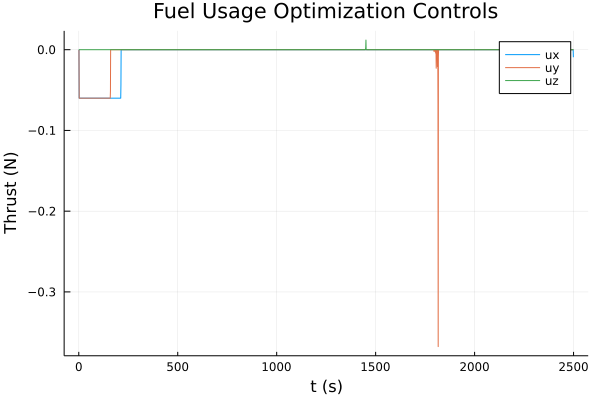

In [145]:
Plots.plot(Um', title="Fuel Usage Optimization Controls",xaxis="t (s)", yaxis="Thrust (N)", labels=["ux" "uy" "uz"])

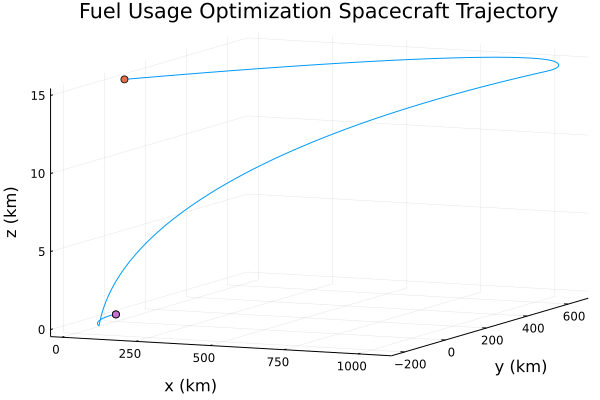

In [146]:
Plots.plot(Xm[1,:],Xm[2,:],Xm[3,:], title="Fuel Usage Optimization Spacecraft Trajectory",xaxis="x (km)", yaxis="y (km)",zaxis="z (km)", legend=false)
Plots.scatter!([Xm[1,1]],[Xm[2,1]],[Xm[3,1]])
Plots.scatter!([0],[0],[0], label = ["x"])
Plots.scatter!([last(Xm[1,:])],[last(Xm[2,:])],[last(Xm[3,:])], label = ["y"])

In [147]:
#total fuel used
print("total fuel", sum(Um'))

total fuel-22.72903199280125

In [148]:
print(Um')

[5.118782349392298e-11 1.533704850455801e-11 1.3004025097575635e-12; -0.05999999825903433 -0.059999998021391596 4.0444280837307864e-12; -0.0599999982516363 -0.05999999800658735 4.7837766667460325e-12; -0.05999999824199275 -0.059999997992027154 5.523136153972317e-12; -0.059999998235691805 -0.05999999797739963 6.262511094125308e-12; -0.0599999982279916 -0.05999999796131685 7.001906036214565e-12; -0.059999998218416666 -0.05999999794581352 7.741325529605442e-12; -0.05999999821004731 -0.059999997930353766 8.480774124078658e-12; -0.05999999820080452 -0.05999999791488984 9.220256369899297e-12; -0.05999999819157214 -0.059999997899387814 9.959776817892134e-12; -0.059999998183846145 -0.05999999788277238 1.0699340019468298e-11; -0.059999998174309385 -0.05999999786613905 1.1438950526734054e-11; -0.05999999816656108 -0.059999997849433585 1.2178612892531489e-11; -0.05999999815720058 -0.05999999783229867 1.2918331670515304e-11; -0.05999999814745221 -0.059999997814928964 1.365811141520491e-11; -0.0599

; -0.05999999345567047 -0.05999987725664992 1.2159485348761852e-10; -0.05999999333587097 -0.05999981568962004 1.2239188483867587e-10; -0.05999999321152973 -0.0599996310026438 1.231896762677597e-10; -0.059999993082428114 -0.05098342735516906 1.2398823318442313e-10; -0.05999999294801866 -2.4640374712131753e-7 1.2478756100973426e-10; -0.0599999928091144 -1.232241569846974e-7 1.25587665176331e-10; -0.05999999266425506 -8.216820996399033e-8 1.2638855112852873e-10; -0.05999999251322803 -6.164099988480789e-8 1.271902243224201e-10; -0.059999992355966855 -4.932493712340041e-8 1.279926902259199e-10; -0.0599999921922654 -4.1114351644263606e-8 1.2879595431892263e-10; -0.05999999202169425 -3.52497178658481e-8 1.2960002209332184e-10; -0.05999999184289406 -3.0851288510971966e-8 1.304048990531568e-10; -0.059999991656207924 -2.743032122030848e-8 1.3121059071466244e-10; -0.05999999146071817 -2.469357333579923e-8 1.320171026064017e-10; -0.05999999125586842 -2.24544372607579e-8 1.3282444026930485e-10; -0.

; -2.4534744227992e-9 -1.7418219696923252e-9 2.538964810689811e-10; -2.4264232077411497e-9 -1.7307985102208136e-9 2.548781044054318e-10; -2.3999299151314077e-9 -1.719924623999255e-9 2.558614934853813e-10; -2.373977456642751e-9 -1.7091973550118028e-9 2.5684665671218553e-10; -2.3485494343910435e-9 -1.6986138251105851e-9 2.5783360251981516e-10; -2.3236301064130695e-9 -1.6881712314711038e-9 2.5882233937300136e-10; -2.299204354195111e-9 -1.6778668441468495e-9 2.5981287576745873e-10; -2.275257652111658e-9 -1.6676980037185277e-9 2.6080522023005305e-10; -2.2517760386444164e-9 -1.6576621190337351e-9 2.617993813189646e-10; -2.228746089261727e-9 -1.6477566650329886e-9 2.627953676239201e-10; -2.2061548908477476e-9 -1.6379791806583142e-9 2.6379318776634694e-10; -2.1839900175790794e-9 -1.6283272668407914e-9 2.647928503995678e-10; -2.1622395081540537e-9 -1.618798584563514e-9 2.6579436420900655e-10; -2.140891844287148e-9 -1.6093908529967846e-9 2.667977379123604e-10; -2.1199359303870956e-9 -1.600101847

; -8.66465087021659e-10 -9.3738318360711e-10 4.24892230648725e-10; -8.623144436918991e-10 -9.348759634867941e-10 4.2625046020061517e-10; -8.58197111907584e-10 -9.323884755411185e-10 4.2761216960925165e-10; -8.54112684180246e-10 -9.299205371995523e-10 4.289773746091188e-10; -8.500607596024129e-10 -9.274719683721593e-10 4.3034609100974353e-10; -8.460409437154386e-10 -9.250425914086877e-10 4.3171833469615e-10; -8.420528483806592e-10 -9.226322310584355e-10 4.3309412162934315e-10; -8.380960916535178e-10 -9.202407144309433e-10 4.344734678467786e-10; -8.341702976607485e-10 -9.178678709574454e-10 4.3585638946284657e-10; -8.302750964804097e-10 -9.155135323530742e-10 4.372429026693645e-10; -8.264101240248379e-10 -9.131775325798237e-10 4.386330237360213e-10; -8.225750219262837e-10 -9.10859707810216e-10 4.400267690109303e-10; -8.18769437425248e-10 -9.08559896391667e-10 4.4142415492107204e-10; -8.14993023261446e-10 -9.062779388115888e-10 4.4282519797281155e-10; -8.112454375672715e-10 -9.04013677663

; -4.770738620056993e-10 -7.158165509128881e-10 6.759404273625933e-10; -4.754245269356126e-10 -7.150672379064748e-10 6.780427687777498e-10; -4.737830838527115e-10 -7.14325190296485e-10 6.801520996994561e-10; -4.721494724030812e-10 -7.135903763714354e-10 6.822684547030944e-10; -4.705236328523575e-10 -7.1286276476313e-10 6.843918685663994e-10; -4.689055060779223e-10 -7.121423244431449e-10 6.865223762709565e-10; -4.672950335613151e-10 -7.114290247192973e-10 6.886600130036318e-10; -4.656921573807295e-10 -7.107228352322613e-10 6.908048141580767e-10; -4.6409682020358345e-10 -7.100237259521267e-10 6.929568153362014e-10; -4.6250896527926163e-10 -7.093316671750874e-10 6.951160523496984e-10; -4.609285364319344e-10 -7.086466295201184e-10 6.972825612215583e-10; -4.593554780534682e-10 -7.079685839257472e-10 6.994563781876e-10; -4.577897350964626e-10 -7.072975016468018e-10 7.016375396979976e-10; -4.5623125306739e-10 -7.066333542512973e-10 7.038260824188661e-10; -4.5467997801985104e-10 -7.05976113617

 -6.722888136544805e-10 1.0863096723320934e-9; -2.946982955491006e-10 -6.724035032721657e-10 1.089966318608061e-9; -2.9378820274081625e-10 -6.725232772702631e-10 1.0936383627667914e-9; -2.92881169153738e-10 -6.726481327972089e-10 1.0973258947894368e-9; -2.9197717909896297e-10 -6.727780671187303e-10 1.1010290053044174e-9; -2.910762170149805e-10 -6.729130776174612e-10 1.1047477855930654e-9; -2.901782674665267e-10 -6.73053161792529e-10 1.1084823275952912e-9; -2.8928331514344143e-10 -6.731983172591414e-10 1.1122327239153423e-9; -2.883913448595608e-10 -6.733485417481918e-10 1.1159990678275864e-9; -2.8750234155162314e-10 -6.735038331058979e-10 1.1197814532823797e-9; -2.8661629027814833e-10 -6.736641892933943e-10 1.1235799749119712e-9; -2.8573317621838827e-10 -6.738296083863785e-10 1.1273947280365197e-9; -2.848529846712345e-10 -6.740000885747463e-10 1.13122580867008e-9; -2.839757010541495e-10 -6.741756281622405e-10 1.1350733135267362e-9; -2.83101310902156e-10 -6.743562255661061e-10 1.13893734

 1.859139406411677e-9; -1.8691993615926634e-10 -7.460695738740741e-10 1.8665477457950117e-9; -1.863426987705961e-10 -7.46969539469946e-10 1.8739964413669795e-9; -1.857671525481758e-10 -7.478753672989083e-10 1.881485790236561e-9; -1.8519329266005655e-10 -7.487870709753403e-10 1.8890160922403094e-9; -1.8462111431326027e-10 -7.497046642393646e-10 1.896587649972446e-9; -1.8405061275350474e-10 -7.506281609573066e-10 1.904200768815454e-9; -1.834817832649147e-10 -7.515575751222665e-10 1.9118557569709186e-9; -1.829146211697817e-10 -7.524929208545658e-10 1.9195529254909e-9; -1.8234912182822979e-10 -7.534342124023219e-10 1.927292588309643e-9; -1.8178528063799682e-10 -7.543814641419244e-10 1.9350750622757284e-9; -1.8122309303413125e-10 -7.553346905786135e-10 1.9429006671845786e-9; -1.8066255448872657e-10 -7.562939063469821e-10 1.9507697258115243e-9; -1.801036605106908e-10 -7.572591262115514e-10 1.9586825639451332e-9; -1.7954640664543153e-10 -7.582303650673057e-10 1.966639510421117e-9; -1.78990788

; -1.1794462604265352e-10 -9.530280028714375e-10 3.6471129587728194e-9; -1.1758136669890108e-10 -9.550240402180908e-10 3.666219401192773e-9; -1.172193922106773e-10 -9.570297392207928e-10 3.685469873696324e-9; -1.1685870133227035e-10 -9.590451420126925e-10 3.704865831450361e-9; -1.1649929283169492e-10 -9.610702910294152e-10 3.7244087480303886e-9; -1.1614116549057986e-10 -9.631052290113445e-10 3.744100115700785e-9; -1.157843181040895e-10 -9.65149999005877e-10 3.763941445699952e-9; -1.1542874948081012e-10 -9.672046443697236e-10 3.783934268530626e-9; -1.1507445844266623e-10 -9.69269208771264e-10 3.804080134255302e-9; -1.1472144382482909e-10 -9.713437361928752e-10 3.824380612797054e-9; -1.1436970447560431e-10 -9.734282709332874e-10 3.8448372942456785e-9; -1.1401923925635206e-10 -9.755228576100216e-10 3.865451789169417e-9; -1.1367004704139482e-10 -9.776275411617519e-10 3.886225728932276e-9; -1.1332212671791745e-10 -9.797423668508006e-10 3.907160766017126e-9; -1.1297547718588435e-10 -9.818673

; -7.717714709731361e-11 -1.395638713534436e-9 9.663808333718902e-9; -7.699982320042714e-11 -1.3998058295459256e-9 9.74321439495501e-9; -7.682370790613115e-11 -1.4039943152477934e-9 9.82358780429168e-9; -7.664880123023783e-11 -1.408204303499269e-9 9.90494434324658e-9; -7.647510319312426e-11 -1.4124359282697336e-9 9.987300116447901e-9; -7.630261381970396e-11 -1.4166893246496412e-9 1.0070671559605382e-8; -7.613133313939255e-11 -1.420964628861641e-9 1.0155075447711455e-8; -7.596126118608334e-11 -1.4252619782718055e-9 1.0240528903480641e-8; -7.579239799811087e-11 -1.4295815114009675e-9 1.0327049406034681e-8; -7.562474361822305e-11 -1.4339233679362337e-9 1.0414654799841901e-8; -7.545829809355557e-11 -1.438287688742593e-9 1.0503363303919342e-8; -7.529306147559261e-11 -1.4426746158746952e-9 1.0593193521306032e-8; -7.5129033820156e-11 -1.4470842925887302e-9 1.0684164448817564e-8; -7.496621518735228e-11 -1.4515168633544881e-9 1.0776295487090553e-8; -7.480460564156193e-11 -1.4559724738675499e-9 

 6.215146276556079e-8; -6.417800058582121e-11 -2.3740598147095133e-9 6.343309513830084e-8; -6.418545712217962e-11 -2.383926296717992e-9 6.475468184690286e-8; -6.419416496803471e-11 -2.3938572485002457e-9 6.611790086380705e-8; -6.420412463875152e-11 -2.403853228542864e-9 6.75245191725086e-8; -6.421533665273213e-11 -2.413914801516332e-9 6.897639849372391e-8; -6.422780153145916e-11 -2.4240425383574997e-9 7.047550144591366e-8; -6.424151979946199e-11 -2.434237016353366e-9 7.20238981782679e-8; -6.42564919843631e-11 -2.444498819226178e-9 7.362377351796693e-8; -6.427271861686767e-11 -2.4548285372198307e-9 7.527743467781876e-8; -6.429020023078585e-11 -2.4652267671876695e-9 7.69873195750653e-8; -6.430893736303969e-11 -2.4756941126816563e-9 7.875600581732655e-8; -6.432893055365441e-11 -2.4862311840429762e-9 8.058622041756741e-8; -6.435018034579961e-11 -2.4968385984940228e-9 8.248085030644941e-8; -6.43726872857879e-11 -2.507516980231903e-9 8.444295371774189e-8; -6.439645192308232e-11 -2.5182669605

 -5.117844200758251e-9 2.1311208553229962e-7; -8.004154975266063e-11 -5.150352439312885e-9 2.053405401838338e-7; -8.024720462320407e-11 -5.183180999999619e-9 1.9798603759789301e-7; -8.045423406793658e-11 -5.2163342948095286e-9 1.910192729351492e-7; -8.066263929551776e-11 -5.249816841113952e-9 1.844134701147378e-7; -8.087242152151846e-11 -5.283633272581142e-9 1.7814412447673043e-7; -8.108358196848426e-11 -5.317788353277139e-9 1.7218877548001602e-7; -8.129612186594431e-11 -5.352286995945916e-9 1.6652680549578352e-7; -8.151004245048663e-11 -5.387134285684276e-9 1.61139261328624e-7; -8.172534496576804e-11 -5.422335510434166e-9 1.5600869557852277e-7; -8.194203066258852e-11 -5.457896199860348e-9 1.5111902536276052e-7; -8.216010079891211e-11 -5.4938221741915065e-9 1.4645540626077888e-7; -8.237955663991647e-11 -5.5301196043891905e-9 1.4200411963578572e-7; -8.2600399458044e-11 -5.5667950844989475e-9 1.3775247173568077e-7; -8.282263053303225e-11 -5.6038557162749485e-9 1.336887031867536e-7; -8.30

; -1.2708503052240014e-10 -2.385773435371189e-8 1.4385975551805018e-8; -1.27515170488783e-10 -2.5368944269966426e-8 1.4244705949127582e-8; -1.2794697116998437e-10 -2.6533121366550036e-8 1.4105485049271176e-8; -1.2838043539794173e-10 -2.722137825786119e-8 1.3968273422489128e-8; -1.288155660198952e-10 -2.7435071353092937e-8 1.3833032583015505e-8; -1.2925236589843468e-10 -2.730466917813089e-8 1.3699724962075812e-8; -1.2969083791150134e-10 -2.7052482476238135e-8 1.3568313881793009e-8; -1.30130984952435e-10 -2.692941278427372e-8 1.3438763529956685e-8; -1.3057280993001869e-10 -2.714387536532404e-8 1.3311038935620761e-8; -1.3101631576850854e-10 -2.7803851479091286e-8 1.3185105945501115e-8; -1.3146150540769586e-10 -2.8889472902430225e-8 1.3060931201141079e-8; -1.3190838180295536e-10 -3.0264423361206756e-8 1.2938482116818105e-8; -1.3235694792527542e-10 -3.1722394965605024e-8 1.2817726858163423e-8; -1.3280720676131711e-10 -3.305364363717967e-8 1.2698634321468471e-8; -1.3325916131343744e-10 -3.41

; -2.1204020277650647e-10 -0.0011958276145847921 4.679688148243991e-9; -2.1275952178651636e-10 -0.02294251430836767 4.652488202623698e-9; -2.134810846607689e-10 -4.865274472895777e-5 4.625516613641124e-9; -2.1420489462379175e-10 -4.989339657674792e-5 4.598770827565749e-9; -2.1493095509702287e-10 -0.0006803205477212397 4.5722483262495445e-9; -2.1565926968568443e-10 -1.6187185441659135e-5 4.545946626533687e-9; -2.1638984184891504e-10 -7.0855497700890165e-6 4.519863279666717e-9; -2.1712267457666483e-10 -0.02083679408083198 4.493995870734018e-9; -2.1785777010844423e-10 -4.1566735337668985e-5 4.468342018098256e-9; -2.1859513087589813e-10 -3.395483316600192e-5 4.442899372850564e-9; -2.1933476043141392e-10 -0.06640119695184654 4.417665618272321e-9; -2.2007666271352742e-10 -0.367714810205851 4.392638469307182e-9; -2.2082084348061184e-10 -0.009233761912097403 4.367815672043206e-9; -2.2156730969884755e-10 -0.00045084776068330767 4.343195003204809e-9; -2.2231606778215557e-10 -4.2206141485748914e-

; -3.492187495806931e-10 -2.0542018193896673e-8 2.2264297718617947e-9; -3.5037237641060556e-10 -2.025582479860546e-8 2.216952503418314e-9; -3.515299095954686e-10 -1.9974764089476103e-8 2.207530978740685e-9; -3.526913683718886e-10 -1.9698699628596914e-8 2.198164757792788e-9; -3.538567721308935e-10 -1.9427567412136207e-8 2.188853404860552e-9; -3.5502614041928967e-10 -1.916136980760748e-8 2.17959648850104e-9; -3.56199492941065e-10 -1.8900167143453332e-8 2.170393581492309e-9; -3.573768495588111e-10 -1.8644067127663257e-8 2.161244260783895e-9; -3.5855823029515254e-10 -1.8393212362711796e-8 2.1521481074480323e-9; -3.597436553341907e-10 -1.8147766314038037e-8 2.1431047066314772e-9; -3.609331450229835e-10 -1.79078981748716e-8 2.134113647508023e-9; -3.621267198730018e-10 -1.7673767147451206e-8 2.125174523231663e-9; -3.633244005616385e-10 -1.744550672542465e-8 2.1162869308903595e-9; -3.6452620793372294e-10 -1.7223209610334247e-8 2.107450471460471e-9; -3.6573216300305925e-10 -1.700691392263194e-8

; -8.216607584788404e-10 -2.8247140041932216e-9 9.191511562265392e-10; -8.250582736672238e-10 -2.737827286968747e-9 9.161524864853078e-10; -8.284770748965818e-10 -2.6668330082290567e-9 9.131653978604135e-10; -8.319173727699801e-10 -2.6133329641446683e-9 9.101898273497106e-10; -8.353793806976561e-10 -2.5782247156775435e-9 9.072257123683164e-10; -8.388633149438184e-10 -2.56168235719057e-9 9.042729907452676e-10; -8.423693946743654e-10 -2.563165957686203e-9 9.013316007201964e-10; -8.458978420056118e-10 -2.5814586151597406e-9 8.98401480940087e-10; -8.494488820538922e-10 -2.6147289981650498e-9 8.954825704559781e-10; -8.53022742986339e-10 -2.6606162949495747e-9 8.925748087197772e-10; -8.566196560725194e-10 -2.716333684776047e-9 8.896781355810584e-10; -8.602398557372558e-10 -2.7787858166498073e-9 8.867924912838932e-10; -8.638835796144601e-10 -2.844695348045439e-9 8.839178164637289e-10; -8.675510686021041e-10 -2.910733372064066e-9 8.810540521442925e-10; -8.712425669183126e-10 -2.973648548742185

; -1.7957836136970039e-9 -1.197880557090534e-9 5.708774071517792e-10; -1.8084736701927522e-9 -1.1913479510295667e-9 5.690887765810787e-10; -1.821327454195378e-9 -1.1853079636526405e-9 5.673055755897113e-10; -1.8343482050989752e-9 -1.1797054421789792e-9 5.655277786179079e-10; -1.8475392484223033e-9 -1.1744809987653272e-9 5.637553602442197e-10; -1.860903998692529e-9 -1.1695727733733991e-9 5.619882951845739e-10; -1.874445962445663e-9 -1.1649180843256468e-9 5.602265582914072e-10; -1.888168741349313e-9 -1.1604549386289942e-9 5.584701245526588e-10; -1.902076035453589e-9 -1.1561233805020903e-9 5.567189690909459e-10; -1.916171646576346e-9 -1.1518666627261225e-9 5.549730671625927e-10; -1.9304594818293378e-9 -1.147632231311525e-9 5.532323941567844e-10; -1.944943557292014e-9 -1.1433725194167986e-9 5.51496925594643e-10; -1.9596280018405045e-9 -1.1390455513944401e-9 5.497666371283444e-10; -1.9745170611392143e-9 -1.1346153621946464e-9 5.480415045402787e-10; -1.9896151018033428e-9 -1.1300522411043997

; -9.725870896176505e-8 -5.492242349642933e-10 3.515051192992116e-10; -1.9093145882786848e-7 -5.469976733957832e-10 3.503061635855441e-10; -3.562117762018906e-7 -5.462240925200455e-10 3.4910995064917474e-10; -0.009330450914101885 -1.155133506891992e-9 3.4791646822873615e-10]

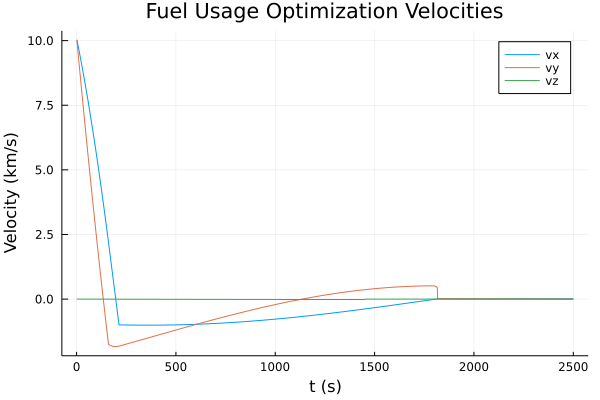

In [152]:
Plots.plot(Xm'[:,4:6], title="Fuel Usage Optimization Velocities", xaxis="t (s)", yaxis = "Velocity (km/s)", labels=["vx" "vy" "vz"])

In [150]:
print(Xm'[:,4:6])

[10.000000000115788 10.000000000049189 5.06467522396909e-12; 10.021708920261922 9.978314485062239 -1.7596569341903255e-5; 9.98334111131539 9.896646991820685 -3.519312042392318e-5; 9.94483161888074 9.815062764407212 -5.2789629543457247e-5; 9.906180488135949 9.733562109687451 -7.038607605793979e-5; 9.867387764419556 9.652145334429298 -8.798243932487399e-5; 9.828453493240955 9.570812745303643 -0.00010557869870185607; 9.789377720276061 9.48956464888058 -0.00012317483354659943; 9.750160491363708 9.408401351631614 -0.000140770823216959; 9.710801852510746 9.327323159928826 -0.00015836664707095542; 9.67130184988904 9.246330380044489 -0.00017596228446679912; 9.631660529834784 9.165423318151756 -0.00019355771476291478; 9.591877938853282 9.084602280322125 -0.00021115291731796528; 9.551954123611951 9.003867572526241 -0.0002287478714908761; 9.51188913094729 8.923219500633826 -0.0002463425566408596; 9.47168300786019 8.842658370412769 -0.0002639369521274387; 9.431335801514013 8.762184487528847 -0.000

 -1.7901094134972795 -0.0029572330231042664; 1.5739999733652177 -1.7935841917349178 -0.0029745337783587088; 1.5138425348200146 -1.7969286566769387 -0.0029918310434261124; 1.4536833205457842 -1.8001428047735142 -0.0030091247980141246; 1.3935224011303078 -1.8032266325415942 -0.003026415021834504; 1.333359847163213 -1.8061801365895207 -0.0030437016946031465; 1.273195729236721 -1.8090033136334365 -0.0030609847960401063; 1.2130301179456513 -1.8116961605085684 -0.0030782643058696237; 1.1528630838874612 -1.8142586741771967 -0.0030955402038201456; 1.0926946976622487 -1.8166908517344071 -0.00311281246962435; 1.0325250298725492 -1.8189926904123364 -0.0031300810830191704; 0.9723541511240947 -1.8211641875833533 -0.003147346023745819; 0.912182132025722 -1.8232053407624873 -0.003164607271549812; 0.8520090431895568 -1.8251161476093063 -0.003181864806180989; 0.791834955230732 -1.8268966059293879 -0.003199118607393544; 0.731659938768544 -1.8285467136754852 -0.0032163686549460412; 0.6714840644256574 -1.

; -1.008972390519731 -1.5586295998053188 -0.005733402203740092; -1.0090010978852642 -1.5564439339203453 -0.005749862994755603; -1.00902862157258 -1.5542582071234152 -0.005766317039605242; -1.0090549615496442 -1.5520724219787405 -0.005782764318984665; -1.0090801177858049 -1.549886581050598 -0.005799204813597458; -1.0091040902517916 -1.5477006869033283 -0.005815638504155156; -1.0091268789197183 -1.545514742101333 -0.005832065371377265; -1.0091484837630804 -1.5433287492090708 -0.005848485395991287; -1.0091689047567571 -1.5411427107910547 -0.005864898558732743; -1.009188141877011 -1.5389566294118493 -0.005881304840345193; -1.0092061951014877 -1.536770507636068 -0.00589770422158026; -1.0092230644092173 -1.5345843480283696 -0.005914096683197651; -1.0092387497806135 -1.5323981531534554 -0.005930482205965182; -1.0092532511974737 -1.530211925576067 -0.005946860770658801; -1.0092665686429803 -1.5280256678609814 -0.0059632323580626045; -1.0092787021016996 -1.5258393825730108 -0.00597959694896887;

 -1.2012161573443594 -0.008329120553442001; -0.9977116325462151 -1.1990547363866075 -0.008344223320069928; -0.9975456178978187 -1.1968936737801106 -0.008359316296585552; -0.997378433021816 -1.19473297206004 -0.008374399465278994; -0.9972100781143478 -1.192572633761145 -0.008389472808451872; -0.9970405533729286 -1.190412661417747 -0.008404536308417301; -0.9968698589964435 -1.1882530575637398 -0.008419589947499929; -0.9966979951851509 -1.1860938247325823 -0.008434633708035951; -0.99652496214068 -1.1839349654573004 -0.008449667572373133; -0.9963507600660313 -1.18177648227048 -0.008464691522870828; -0.9961753891655776 -1.1796183777042661 -0.008479705541899996; -0.9959988496450615 -1.1774606542903605 -0.008494709611843235; -0.9958211417115971 -1.175303314560016 -0.00850970371509479; -0.9956422655736691 -1.1731463610440367 -0.008524687834060575; -0.9954622214411316 -1.1709897962727722 -0.008539661951158205; -0.9952810095252094 -1.1688336227761167 -0.008554626048816997; -0.9950986300384971 -1

 -0.8533475871060399 -0.010662689824894862; -0.9550251517486631 -0.8512784293976828 -0.010675959179805943; -0.95467082376609 -0.8492100380206518 -0.0106892160081885; -0.9543153758538238 -0.8471424154013951 -0.01070246029448155; -0.9539588084288454 -0.8450755639654589 -0.010715692023138778; -0.95360112190945 -0.8430094861374853 -0.01072891117862855; -0.9532423167152451 -0.8409441843412081 -0.010742117745433937; -0.9528823932671502 -0.8388796609994511 -0.010755311708052724; -0.9525213519873974 -0.8368159185341248 -0.010768493050997432; -0.9521591932995295 -0.8347529593662237 -0.010781661758795339; -0.9517959176284001 -0.8326907859158234 -0.010794817815988495; -0.9514315254001736 -0.8306294006020774 -0.010807961207133735; -0.9510660170423236 -0.8285688058432151 -0.010821091916802705; -0.9506993929836337 -0.8265090040565383 -0.010834209929581878; -0.9503316536541957 -0.8244499976584183 -0.010847315230072565; -0.9499627994854101 -0.8223917890642937 -0.010860407802890942; -0.9495928309099848

 -0.5259710135402965 -0.012660645277313339; -0.8822850032204614 -0.5240592335596785 -0.012671663379409365; -0.8817535123587963 -0.5221486037739826 -0.012682666611310803; -0.8812209871075838 -0.5202391264245844 -0.012693654960085718; -0.8806874280915346 -0.5183308037515076 -0.012704628412819479; -0.8801528359365721 -0.5164236379934216 -0.012715586956614771; -0.8796172112698322 -0.5145176313876384 -0.012726530578591617; -0.8790805547196616 -0.5126127861701099 -0.01273745926588738; -0.8785428669156176 -0.5107091045754262 -0.012748373005656781; -0.8780041484884671 -0.508806588836812 -0.012759271785071925; -0.8774644000701863 -0.5069052411861243 -0.012770155591322292; -0.8769236222939599 -0.5050050638538501 -0.012781024411614767; -0.8763818157941796 -0.503106059069103 -0.012791878233173652; -0.8758389812064442 -0.5012082290596216 -0.012802717043240678; -0.8752951191675585 -0.4993115760517658 -0.012813540829075012; -0.8747502303155326 -0.49741610227051547 -0.012824349577953283; -0.8742043152

; -0.7831613629036999 -0.2310844057450012 -0.014251603772986328; -0.7824712697399854 -0.22938866952570083 -0.014260039913973744; -0.7817802586557842 -0.22769442918194802 -0.01426845931406062; -0.7810883304617292 -0.22600168670127238 -0.014276861963289316; -0.7803954859695296 -0.22431044406944645 -0.014285247851721136; -0.779701725991969 -0.22262070327048328 -0.014293616969436332; -0.7790070513429054 -0.22093246628663418 -0.014301969306534108; -0.7783114628372697 -0.2192457350983863 -0.014310304853132623; -0.7776149612910649 -0.2175605116844604 -0.014318623599368996; -0.7769175475213648 -0.21587679802180834 -0.014326925535399312; -0.7762192223463139 -0.21419459608561112 -0.01433521065139862; -0.7755199865851256 -0.21251390784927623 -0.014343478937560935; -0.7748198410580812 -0.21083473528443547 -0.014351730384099252; -0.7741187865865299 -0.20915708036094255 -0.014359964981245539; -0.7734168239928868 -0.207480945046871 -0.014368182719250737; -0.7727139541006325 -0.2058063313085116 -0.014

; -0.6608150952932481 0.02135478647224957 -0.015387912479179556; -0.6599883656100383 0.02278534783586043 -0.015393537958677537; -0.6591608616926576 0.024214117495649758 -0.015399145335071465; -0.6583325845118637 0.025641093775506347 -0.015404734601331911; -0.6575035350393214 0.027066275001422748 -0.01541030575044461; -0.6566737142476012 0.028489659501497226 -0.01541585877541037; -0.6558431231101789 0.029911245605935718 -0.01542139366924498; -0.6550117626014338 0.031331031647053795 -0.015426910424979115; -0.6541796336966478 0.03274901595927861 -0.01543240903565822; -0.6533467373720043 0.03416519687915085 -0.015437889494342424; -0.652513074604587 0.035579572745326714 -0.015443351794106417; -0.6516786463723787 0.03699214189857983 -0.015448795928039365; -0.6508434536542603 0.038402902681803214 -0.015454221889244784; -0.6500074974300095 0.0398118534400112 -0.01545962967084042; -0.6491707786802996 0.04121899252034141 -0.015465019265958153; -0.6483332983866987 0.042624318272056656 -0.01547039

 0.23087205887285714 -0.016063693634925456; -0.5146688318716968 0.23198795099134514 -0.01606625943698984; -0.5137281198645752 0.23310180598535554 -0.016068805911212673; -0.5127868052040302 0.23421362254817768 -0.016071333043868093; -0.5118448889943419 0.23532339937549185 -0.016073840820930524; -0.5109023723404962 0.2364311351653708 -0.01607632922806248; -0.5099592563481827 0.2375368286182813 -0.01607879825060184; -0.5090155421237957 0.2386404784370856 -0.01608124787354856; -0.50807123077443 0.2397420833270431 -0.016083678081550687; -0.5071263234078816 0.24084164199581165 -0.0160860888588898; -0.5061808211326456 0.24193915315344927 -0.016088480189465734; -0.5052347250579157 0.2430346155124155 -0.016090852056780562; -0.5042880362935813 0.24412802778757287 -0.016093204443921833; -0.5033407559502281 0.24521938869618876 -0.01609553733354499; -0.5023928851391354 0.24630869695793647 -0.01609785070785492; -0.501444424972275 0.24739595129489683 -0.01610014454858663; -0.5004953765623115 0.248481

 0.3857778308210372 -2.1546199654391957e-5; -0.35315330685688556 0.38654393636423096 -2.0738276523089884e-5; -0.3521289905525073 0.3873078234562145 -1.9986301596632862e-5; -0.35110426117297255 0.3880694912006522 -1.9284672376241077e-5; -0.3500791199204555 0.3888289387038094 -1.86285095321094e-5; -0.34905356799761333 0.389586165074553 -1.8013543938165558e-5; -0.348027606607586 0.390341169424353 -1.743602423153709e-5; -0.34700123695399426 0.391093950867283 -1.68926406753283e-5; -0.34597446024093814 0.39184450852002145 -1.6380462067000133e-5; -0.344947277672996 0.39259284150185286 -1.589688315776634e-5; -0.3439196904552225 0.3933389489346681 -1.543958059586862e-5; -0.3428916997931479 0.3940828299429662 -1.500647582454023e-5; -0.3418633068927761 0.3948244836538547 -1.459570368707373e-5; -0.34083451296058354 0.395563909197051 -1.4205585740729058e-5; -0.33980531920351753 0.39630110570488297 -1.3834607475861714e-5; -0.33877572682899515 0.3970360723122905 -1.3481398789620984e-5; -0.33774573704

; -0.1826754264009724 0.480802194320028 -2.330624022561153e-6; -0.1816001668228775 0.48119672379767064 -2.3145953865534965e-6; -0.18052469424785908 0.4815889228814605 -2.298738726201781e-6; -0.1794490099395797 0.48197879111994857 -2.2830513426247805e-6; -0.17837311516173834 0.48236632824287823 -2.267530592818683e-6; -0.1772970111777237 0.4827515341231423 -2.252173888221242e-6; -0.17622069925039316 0.48313440869860824 -2.236978693319959e-6; -0.17514418064204607 0.4835149518709891 -2.2219425243027007e-6; -0.17406745661461395 0.4838931634066492 -2.2070629477492764e-6; -0.17299052843003457 0.48426904286584643 -2.1923375793625176e-6; -0.17191339735072633 0.48464258958137174 -2.177764082737484e-6; -0.17083606464004492 0.48501380269572114 -2.1633401681674577e-6; -0.1697585315626031 0.4853826812506187 -2.1490635914854617e-6; -0.16868079938436245 0.48574922430796547 -2.1349321529400637e-6; -0.16760286937246247 0.4861134310713845 -2.120943696104297e-6; -0.1665247427948211 0.48647530097569314 -2.

 0.0112085234784319 -6.028230688832961e-7; 0.007468832311780384 0.011192301030068658 -6.002384315540742e-7; 0.007474895421450415 0.011176066419558905 -5.976660090374081e-7; 0.007480949655909749 0.011159819639864562 -5.951057196605925e-7; 0.0074869950100954225 0.0111435606860582 -5.925574824770336e-7; 0.007493031478904616 0.011127289555135348 -5.900212172582789e-7; 0.007499059057198596 0.011111006245823124 -5.874968444861515e-7; 0.007505077739806238 0.011094710758387237 -5.849842853449864e-7; 0.007511087521527127 0.011078403094439387 -5.824834617139675e-7; 0.007517088397134261 0.011062083256747205 -5.799942961595663e-7; 0.007523080361376326 0.011045751249048857 -5.775167119280765e-7; 0.007529063408979588 0.011029407075874315 -5.750506329382471e-7; 0.0075350375346494095 0.011013050742375269 -5.725959837740104e-7; 0.007541002733071397 0.010996682254165505 -5.701526896773024e-7; 0.007546958998912229 0.010980301617173355 -5.677206765409782e-7; 0.0075529063268201775 0.010963908837507665 -5.6

 0.008499981089727791 -3.0682625408904457e-7; 0.008313067033822822 0.008481970612050676 -3.0548542682996703e-7; 0.008317656903959145 0.008463950446273325 -3.041495402860011e-7; 0.00832223699884946 0.008445920592778235 -3.028185703507756e-7; 0.008326807313613323 0.008427881045862276 -3.0149249307954907e-7; 0.00833136784331779 0.00840983179457229 -3.0017128468788257e-7; 0.008335918582967113 0.008391772823723335 -2.988549215503266e-7; 0.00834045952749483 0.0083737041150666 -2.975433801991216e-7; 0.008344990671758498 0.008355625648568685 -2.9623663732290954e-7; 0.008349512010537257 0.008337537403759537 -2.9493466976545886e-7; 0.008354023538532367 0.008319439361103563 -2.9363745452440165e-7; 0.008358525250370652 0.008301331503347269 -2.923449687499836e-7; 0.008363017140610829 0.008283213816797017 -2.910571897438252e-7; 0.008367499203752444 0.008265086292482732 -2.8977409495769527e-7; 0.00837197143424719 0.008246948927166766 -2.8849566199229693e-7; 0.008376433826512176 0.008228801724162396 -

; 0.00890788304519884 0.005564552202946439 -1.447133718510993e-7; 0.008910890979832584 0.005545249703439031 -1.4393048732330378e-7; 0.008913888450469048 0.005525940771601268 -1.4315013257567603e-7; 0.00891687545372945 0.005506625438119916 -1.423722982906741e-7; 0.008919851986261619 0.005487303731164226 -1.415969752016936e-7; 0.008922818044734375 0.005467975676240464 -1.4082415409273406e-7; 0.008925773625831702 0.005448641296150604 -1.400538257980674e-7; 0.008928718726246926 0.005429300611053684 -1.39285981201909e-7; 0.008931653342677167 0.005409953638624419 -1.3852061123809148e-7; 0.00893457747181819 0.0053906003943001955 -1.37757706889741e-7; 0.008937491110359904 0.005371240891604453 -1.3699725918895635e-7; 0.00894039425498261 0.005351875142532035 -1.3623925921648973e-7; 0.008943286902354148 0.005332503157980158 -1.3548369810143102e-7; 0.008946169049127992 0.005313124948207534 -1.3473056702089382e-7; 0.008949040691942358 0.005293740523303664 -1.339798571997043e-7; 0.00895190182742033 

 -4.839374998933155e-8; 0.009250059732848946 0.002469117231032366 -4.791808353014108e-8; 0.00925138929318842 0.002449077266327497 -4.744395046865942e-8; 0.009252707978403312 0.0024290344398430223 -4.697134659419909e-8; 0.00925401578663862 0.0024089887750833637 -4.650026771612115e-8; 0.009255312716043946 0.0023889402955423046 -4.603070966372676e-8; 0.009256598764773203 0.002368889024705111 -4.5562668286149675e-8; 0.00925787393098431 0.0023488349860507464 -4.509613945224954e-8; 0.009259138212838875 0.0023287782030541244 -4.463111905050562e-8; 0.009260391608501893 0.002308718699188351 -4.4167602988911424e-8; 0.009261634116141408 0.00228865649792691 -4.3705587194869934e-8; 0.009262865733928177 0.00226859162274576 -4.324506761508972e-8; 0.009264086460035336 0.0022485240971252944 -4.278604021548147e-8; 0.009265296292638028 0.002228453944552147 -4.232850098105528e-8; 0.00926649522991304 0.002208381188520812 -4.187244591581882e-8; 0.009267683270038431 0.0021883058525350653 -4.1417871042675865e